<a href="https://colab.research.google.com/github/saeedzou/Deep-Learning-Project/blob/dev-saeed/Phase%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This block downloads and preprocesses the needed data for the project
!git clone https://github.com/XL2248/MSCTD
!cp MSCTD/MSCTD_data/ende/eng* .
!cp MSCTD/MSCTD_data/ende/ima* .
!cp MSCTD/MSCTD_data/ende/sent* .
!rm -rf MSCTD
!mkdir train
!mkdir dev
!mkdir test
!mv *train.txt train
!mv *dev.txt dev
!mv *test.txt test

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 11.73 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.
mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘dev’: File exists
mkdir: cannot create directory ‘test’: File exists


In [3]:
import numpy as np
import pandas as pd
import nltk
import nltk.tokenize as tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import string
import re
import random
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
class MSCTD(Dataset):
    """
    :param root: root path of the dataset
    :param split: train, dev, test
    :param image_transform: transform for image
    :param text_transform: transform for text
    :param sentiment_transform: transform for sentiment
    :param has_data: dict, whether the dataset has image, text
    :param text_path: path of the text file
    :param image_path: path of the image folder
    :param sentiment_path: path of the sentiment file
    :param image_index_path: path of the image index file

    :return: combination of image, sentiment, text, image_index

    Example:
    >>> from torchvision import transforms
    >>> image_transform = transforms.Compose([
    >>>     transforms.Resize((640, 1280)),
    >>>     transforms.Lambda(lambda x: x.permute(1, 2, 0))
    >>> ])
    >>> text_transform = None
    >>> sentiment_transform = None
    >>> dataset = MSCTD(root='data', split='train', image_transform=image_transform,
    >>>                 text_transform=text_transform, sentiment_transform=sentiment_transform)
    >>> image, text, sentiment = dataset[0]

    """
    def __init__(self, root, split, image_transform=None, text_transform=None, sentiment_transform=None,
                 has_data={'image': True, 'text': True}, text_path=None, image_path=None, sentiment_path=None,
                 image_index_path=None):
        data_path = os.path.join(root, split)
        default_path = {
            'text': os.path.join(data_path, 'english_' + split + '.txt'),
            'image': os.path.join(data_path, 'image'),
            'sentiment': os.path.join(data_path, 'sentiment_' + split + '.txt'),
            'image_index': os.path.join(data_path, 'image_index_' + split + '.txt'),
        }
        self.image = [] if has_data['image'] else None
        self.image_transform = image_transform
        self.image_path = image_path if image_path else default_path['image']
        self.text = [] if has_data['text'] else None
        self.text_transform = text_transform
        self.text_path = text_path if text_path else default_path['text']
        self.sentiment_path = sentiment_path if sentiment_path else default_path['sentiment']
        self.image_index_path = image_index_path if image_index_path else default_path['image_index']
        self.sentiment = []
        self.image_index = []
        self.sentiment_transform = sentiment_transform
        self.load_data()
        
    def load_data(self):
        self.sentiment = np.loadtxt(self.sentiment_path, dtype=int)
        if self.text is not None:
            with open(self.text_path, 'r') as f:
                self.text = f.readlines()
            self.text = [x.strip() for x in self.text]
        with open(self.image_index_path, 'r') as f:
            data = f.readlines()
        self.image_index = [list(map(int, x[1:-2].split(','))) for x in data]

    def __getitem__(self, index):
        image = None
        text = None
        sentiment = self.sentiment[index]
        if self.image is not None:
            imag_path = os.path.join(self.image_path, str(index)+'.jpg')
            image = read_image(imag_path)
            if self.image_transform:
                image = self.image_transform(image)
        if self.text is not None:
            text = self.text[index]
            if self.text_transform:
                text = self.text_transform(text)
        if self.sentiment_transform:
            sentiment = self.sentiment_transform(sentiment)
        if text is not None and image is not None:
            return image, text, sentiment
        elif text is not None:
            return text, sentiment
        elif image is not None:
            return image, sentiment
        else:
            raise Exception('Either image or text should be not None')

    def __len__(self):
        return len(self.sentiment)

In [5]:
MSCTD_train = MSCTD(root='.', split='train', has_data={'image': False, 'text': True})
MSCTD_dev = MSCTD(root='.', split='dev', has_data={'image': False, 'text': True})
MSCTD_test = MSCTD(root='.', split='test', has_data={'image': False, 'text': True})

In [6]:
def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNetLemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def text_preprocessor(dataset):
      # preprocess text
      dataset.text = [preprocess_text(text) for text in dataset.text]

def preprocess_text(text):
      # Replace contractions with original text
  text = re.sub(r'(\b[Aa]in\'t\b)', "am not", text)
  text = re.sub(r'(\b[Hh]a\'t\b)', "has", text)
  text = re.sub(r'(\b[Ii]\'m\b)', "i am", text)
  text = re.sub(r'(\b\'s\b)', " is", text)
  text = re.sub(r'(\b\'re\b)', " are", text)
  text = re.sub(r'(\b\'ve\b)', " have", text)
  text = re.sub(r'(\b\'d\b)', " would", text)
  text = re.sub(r'(\b\'ll\b)', " will", text)
  text = re.sub(r'(\b[Ss]han\'t\b)', "shall not", text)
  text = re.sub(r'(\b[Ww]on\'t\b)', "will not", text)
  text = re.sub(r'(\b[Ww]ouldn\'t\b)', "would not", text)
  text = re.sub(r'(\b[Dd]on\'t\b)', "do not", text)
  text = re.sub(r'(\b[Cc]an\'t\b)', "can not", text)
  text = re.sub(r'(\b[Ii]s\'nt\b)', "is not", text)
  text = re.sub(r'(\b[Ww]eren\'t\b)', "were not", text)
  text = re.sub(r'(\b[Hh]aven\'t\b)', "have not", text)
  text = re.sub(r'(\b[Hh]adn\'t\b)', "had not", text)
  text = re.sub(r'(\b[Hh]asn\'t\b)', "has not", text)
  text = re.sub(r'(\b[Hh]adn\'t\b)', "had not", text)
  text = re.sub(r'(\b[Dd]idn\'t\b)', "did not", text)

  # Remove punctuation
  text = text.translate(str.maketrans("", "", string.punctuation))

  # Convert to lowercase
  text = text.lower()

  # Tokenize text
  tokens = word_tokenize(text)

  # Remove stop words
  # tokens = [token for token in tokens if token not in stop_words]
  # Remove numbers
  tokens = [token for token in tokens if token.isalpha()]

  # Lemmatize tokens
  tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

  return ' '.join(tokens)

# Test the TextPreprocessor
text_preprocessor(MSCTD_train)
text_preprocessor(MSCTD_dev)
text_preprocessor(MSCTD_test)

# TF-IDF Method

In [7]:
class TFIDFProcessor:
    def __init__(self, dataset):
        self.dataset = dataset
        self.tfidf = TfidfVectorizer()
        self.tfidf_matrix = None

    def fit(self):
        # Get all the captions from the dataset
        captions = [caption for caption, _ in self.dataset]

        # Fit the TF-IDF model on the captions
        self.tfidf_matrix = self.tfidf.fit_transform(captions)

    def transform(self, caption):
        # Transform the input caption using the fitted TF-IDF model
        tfidf_vector = self.tfidf.transform([caption])

        # Convert the resulting sparse matrix to a dense numpy array
        return np.array(tfidf_vector.todense()).squeeze(0)

    def __getitem__(self, index):
        # Get the caption and sentiment from the dataset
        caption, sentiment = self.dataset[index]

        # Transform the caption using the TF-IDF model
        tfidf_vector = self.transform(caption)

        return tfidf_vector, sentiment

In [8]:
tfidf_processor = TFIDFProcessor(MSCTD_train)
tfidf_processor.fit()

In [9]:
class TFIDFDataSet:
    def __init__(self, dataset, tfidf_processor):
        self.dataset = dataset
        self.tfidf_processor = tfidf_processor
        
    def __getitem__(self, index):
        # Get the caption and sentiment from the MSCTD dataset
        caption, sentiment = self.dataset[index]

        # Convert the caption to a TF-IDF vector using the TFIDFProcessor
        tfidf_vector = self.tfidf_processor.transform(caption)

        # Return the TF-IDF vector and sentiment
        return torch.from_numpy(tfidf_vector.astype(np.float32)), torch.from_numpy(np.array(sentiment))

    def __len__(self):
        return len(self.dataset)

In [10]:
train_dataset = TFIDFDataSet(MSCTD_train, tfidf_processor)
dev_dataset = TFIDFDataSet(MSCTD_dev, tfidf_processor)
test_dataset = TFIDFDataSet(MSCTD_dev, tfidf_processor)

In [11]:
# data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [12]:
class MLPClassifier(nn.Module):
  def __init__(self, input_size, num_classes):
    super(MLPClassifier, self).__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, x):
    return self.linear(x)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_size = len(tfidf_processor.tfidf.get_feature_names_out())
num_classes = 3
model = MLPClassifier(input_size, num_classes)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Train the model for 10 epochs
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []
for epoch in range(10):
    running_loss = 0.0
    running_acc = 0.0
    for i, (tfidf, sentiment) in enumerate(train_loader):
        tfidf = tfidf.to(device)
        sentiment = sentiment.to(device)
        
        outputs = model(tfidf)
        # if i > 630:
        #   print(tfidf.shape, sentiment.shape, outputs.shape)
        loss = loss_fn(outputs, sentiment)
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
    train_loss.append(running_loss / len(train_loader))
    train_acc.append(running_acc / len(train_loader.dataset))
    print(f'Epoch {epoch+1}/{10}, Training Loss: {train_loss[-1]:.4f}, Training Accuracy: {train_acc[-1]:.4f}')
    # Evaluate on the dev set
    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for i, (tfidf, sentiment) in enumerate(dev_loader):
            tfidf = tfidf.to(device)
            sentiment = sentiment.to(device)
            outputs = model(tfidf)
            loss = loss_fn(outputs, sentiment)
            running_loss += loss.item()
            running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
        dev_loss.append(running_loss / len(dev_loader))
        dev_acc.append(running_acc / len(dev_loader.dataset))
        print(f'Epoch {epoch+1}/{10}, Dev Loss: {dev_loss[-1]:.4f}, Dev Accuracy: {dev_acc[-1]:.4f}')

Epoch 1/10, Training Loss: 1.0715, Training Accuracy: 0.4095
Epoch 1/10, Dev Loss: 1.0635, Dev Accuracy: 0.4179
Epoch 2/10, Training Loss: 1.0285, Training Accuracy: 0.5227
Epoch 2/10, Dev Loss: 1.0409, Dev Accuracy: 0.4707
Epoch 3/10, Training Loss: 0.9942, Training Accuracy: 0.5741
Epoch 3/10, Dev Loss: 1.0235, Dev Accuracy: 0.4989
Epoch 4/10, Training Loss: 0.9660, Training Accuracy: 0.6067
Epoch 4/10, Dev Loss: 1.0118, Dev Accuracy: 0.5048
Epoch 5/10, Training Loss: 0.9419, Training Accuracy: 0.6239
Epoch 5/10, Dev Loss: 1.0032, Dev Accuracy: 0.5066
Epoch 6/10, Training Loss: 0.9208, Training Accuracy: 0.6369
Epoch 6/10, Dev Loss: 0.9956, Dev Accuracy: 0.5100
Epoch 7/10, Training Loss: 0.9021, Training Accuracy: 0.6456
Epoch 7/10, Dev Loss: 0.9883, Dev Accuracy: 0.5116
Epoch 8/10, Training Loss: 0.8856, Training Accuracy: 0.6541
Epoch 8/10, Dev Loss: 0.9859, Dev Accuracy: 0.5157
Epoch 9/10, Training Loss: 0.8705, Training Accuracy: 0.6629
Epoch 9/10, Dev Loss: 0.9824, Dev Accuracy:

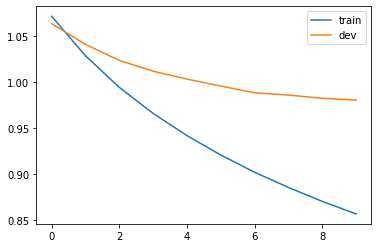

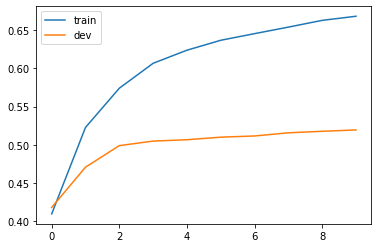

In [14]:
plt.plot(train_loss, label='train')
plt.plot(dev_loss, label='dev')
plt.legend()
plt.show()
plt.plot(train_acc, label='train')
plt.plot(dev_acc, label='dev')
plt.legend()
plt.show()

In [15]:
# evaluate on the test set
with torch.no_grad():
    running_loss = 0.0
    running_acc = 0.0
    for i, (tfidf, sentiment) in enumerate(test_loader):
        tfidf = tfidf.to(device)
        sentiment = sentiment.to(device)
        outputs = model(tfidf)
        loss = loss_fn(outputs, sentiment)
        running_loss += loss.item()
        running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
    test_loss = running_loss / len(test_loader)
    test_acc = running_acc / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.9790, Test Accuracy: 0.5195


# SVM on TFIDF Vectors for Word2Vec

In [16]:
# build a dictionary where the keys are the words and the values are columns in the tfidf matrix corresponding to the words
tfidf_dict = {word: tfidf_processor.tfidf_matrix[:, i].toarray().squeeze(1) for i, word in enumerate(tfidf_processor.tfidf.get_feature_names_out())}
word_vectors = {word:[] for word in tfidf_dict.keys()}

In [17]:
# create dataloaders for MSCTD_train, MSCTD_dev, MSCTD_test
MSCTD_train_loader = DataLoader(MSCTD_train, batch_size=32, shuffle=True)
MSCTD_dev_loader = DataLoader(MSCTD_dev, batch_size=32, shuffle=True)
MSCTD_test_loader = DataLoader(MSCTD_test, batch_size=32, shuffle=True)

In [18]:
for i, (captions, _) in enumerate(MSCTD_train_loader):
    print(f'Processing batch {i+1}') if i % 50 == 0 else None
    for caption in captions:
        for word in caption.split():
            if word in tfidf_dict.keys():
                tfidf = tfidf_dict[word]
                pos = [(tfidf_dict[i], 1) for i in caption.split() if i != word and i in tfidf_dict.keys()]
                if len(pos) > 4:
                    neg = [(tfidf_dict[i], 0) for i in np.random.choice(list(tfidf_dict.keys()), len(pos)) if i not in caption.split()]
                    # create a shuffled numpy array of pos and neg
                    combined = pos + neg
                    random.shuffle(combined)
                    # fit a linearsvc model on the combined array
                    model = LinearSVC(max_iter=10000)
                    model.fit(np.array([x for x, _ in combined]), np.array([y for _, y in combined]))
                    # add the weights and bias to the word_vectors dictionary. e.g) if params are w and b then word_vectors[word] = [w.T, b].T
                    weights = np.concatenate((model.coef_.squeeze(0), model.intercept_))
                    if not word_vectors[word]:
                        word_vectors[word].append([weights, 1])
                    else:
                        word_vectors[word][0][0] += weights
                        word_vectors[word][0][1] += 1
            

Processing batch 0
Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Processing batch 5
Processing batch 6
Processing batch 7
Processing batch 8
Processing batch 9
Processing batch 10
Processing batch 11
Processing batch 12
Processing batch 13
Processing batch 14
Processing batch 15
Processing batch 16
Processing batch 17
Processing batch 18
Processing batch 19
Processing batch 20
Processing batch 21
Processing batch 22
Processing batch 23
Processing batch 24
Processing batch 25
Processing batch 26
Processing batch 27
Processing batch 28
Processing batch 29
Processing batch 30
Processing batch 31
Processing batch 32
Processing batch 33
Processing batch 34
Processing batch 35
Processing batch 36
Processing batch 37
Processing batch 38
Processing batch 39
Processing batch 40
Processing batch 41
Processing batch 42
Processing batch 43
Processing batch 44
Processing batch 45
Processing batch 46
Processing batch 47
Processing batch 48
Processing batch 49
Processing

In [31]:
# average the weights and bias
len_of_weights = len(word_vectors['the'][0][0])
for word in word_vectors.keys():
    if len(word_vectors[word]) > 0:
        word_vectors[word][0] = word_vectors[word][0][0] / word_vectors[word][0][1]
    else:
        word_vectors[word].append(np.zeros(len_of_weights))

In [51]:
# define a SVMEmbedding class
class SVMEmbedding:
    def __init__(self, embeddings):
        self.embeddings = embeddings
        self.dim = list(embeddings.values())[0][0].shape[0]
    def __call__(self, caption):
        # return the average of the word embeddings of the words in the caption
        words = caption.split()
        words = [word for word in words if word in self.embeddings.keys()]
        if len(words) == 0:
            return np.zeros(self.dim)
        else:
            return np.mean([self.embeddings[word][0] for word in words], axis=0)

# create a SVMEmbedding object
svm_embedding = SVMEmbedding(word_vectors)
# Test the SVMEmbedding object
print(svm_embedding('the cat is on the mat'))

[ 1.39692992e-04  7.47700796e-04  1.26360773e-03 ...  5.81882222e-04
  8.68989388e-05 -6.38371230e-01]


In [52]:
class SVMDataset(Dataset):
    def __init__(self, dataset, embedding):
        self.dataset = dataset
        self.embedding = embedding
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        caption, sentiment = self.dataset[idx]
        embedding = self.embedding(caption)
        return embedding, sentiment

train_dataset = SVMDataset(MSCTD_train, svm_embedding)
dev_dataset = SVMDataset(MSCTD_dev, svm_embedding)
test_dataset = SVMDataset(MSCTD_test, svm_embedding)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [63]:
input_size = len_of_weights
num_classes = 3
model = MLPClassifier(input_size, num_classes)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [64]:
# Train the model for 10 epochs
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []
for epoch in range(10):
    running_loss = 0.0
    running_acc = 0.0
    for i, (embedding, sentiment) in enumerate(train_loader):
        embedding = embedding.to(device)
        sentiment = sentiment.to(device)
        outputs = model(embedding.float())
        loss = loss_fn(outputs, sentiment)
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
    train_loss.append(running_loss / len(train_loader))
    train_acc.append(running_acc / len(train_loader.dataset))
    print(f'Epoch {epoch+1}/{10}, Training Loss: {train_loss[-1]:.4f}, Training Accuracy: {train_acc[-1]:.4f}')
    # Evaluate on the dev set
    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for i, (embedding, sentiment) in enumerate(dev_loader):
            embedding = embedding.to(device)
            sentiment = sentiment.to(device)
            outputs = model(embedding.float())
            loss = loss_fn(outputs, sentiment)
            running_loss += loss.item()
            running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
        dev_loss.append(running_loss / len(dev_loader))
        dev_acc.append(running_acc / len(dev_loader.dataset))
        print(f'Epoch {epoch+1}/{10}, Dev Loss: {dev_loss[-1]:.4f}, Dev Accuracy: {dev_acc[-1]:.4f}')
        

Epoch 1/10, Training Loss: 1.0801, Training Accuracy: 0.4076
Epoch 1/10, Dev Loss: 1.0834, Dev Accuracy: 0.4053
Epoch 2/10, Training Loss: 1.0632, Training Accuracy: 0.4425
Epoch 2/10, Dev Loss: 1.0737, Dev Accuracy: 0.4245
Epoch 3/10, Training Loss: 1.0489, Training Accuracy: 0.4648
Epoch 3/10, Dev Loss: 1.0734, Dev Accuracy: 0.4102
Epoch 4/10, Training Loss: 1.0379, Training Accuracy: 0.4779
Epoch 4/10, Dev Loss: 1.0634, Dev Accuracy: 0.4341
Epoch 5/10, Training Loss: 1.0284, Training Accuracy: 0.4892
Epoch 5/10, Dev Loss: 1.0597, Dev Accuracy: 0.4393
Epoch 6/10, Training Loss: 1.0201, Training Accuracy: 0.4997
Epoch 6/10, Dev Loss: 1.0574, Dev Accuracy: 0.4466
Epoch 7/10, Training Loss: 1.0124, Training Accuracy: 0.5081
Epoch 7/10, Dev Loss: 1.0540, Dev Accuracy: 0.4511
Epoch 8/10, Training Loss: 1.0061, Training Accuracy: 0.5119
Epoch 8/10, Dev Loss: 1.0502, Dev Accuracy: 0.4632
Epoch 9/10, Training Loss: 0.9999, Training Accuracy: 0.5173
Epoch 9/10, Dev Loss: 1.0486, Dev Accuracy:

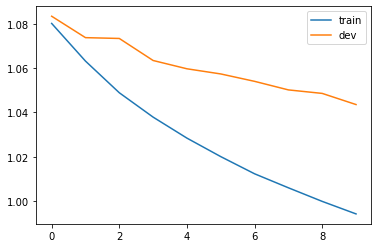

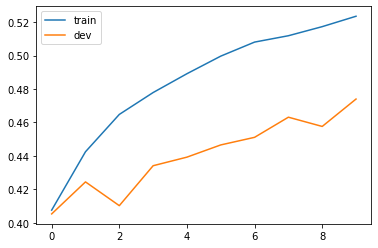

In [65]:
plt.plot(train_loss, label='train')
plt.plot(dev_loss, label='dev')
plt.legend()
plt.show()
plt.plot(train_acc, label='train')
plt.plot(dev_acc, label='dev')
plt.legend()
plt.show()

In [67]:
# evaluate on the test set
with torch.no_grad():
    running_loss = 0.0
    running_acc = 0.0
    for i, (embedding, sentiment) in enumerate(test_loader):
        embedding = embedding.to(device)
        sentiment = sentiment.to(device)
        outputs = model(embedding.float())
        loss = loss_fn(outputs, sentiment)
        running_loss += loss.item()
        running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
    test_loss = running_loss / len(test_loader)
    test_acc = running_acc / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 1.0383, Test Accuracy: 0.4910


# GloVe 

In [39]:
# download glove embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-02-04 13:23:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-04 13:23:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-04 13:23:16--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [114]:
glove_embeddings = {}
with open('glove.6B.50d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], 'float32')
        glove_embeddings[word] = vector

class GloveEmbedding:
    def __init__(self, embeddings):
        self.embeddings = embeddings
        self.dim = list(embeddings.values())[0].shape[0]
        
    def __call__(self, caption):
        words = caption.split()
        vectors = [self.embeddings.get(word, np.zeros(self.dim)) for word in words]
        if len(vectors) == 0:
            return np.zeros(self.dim)
        return np.mean(vectors, axis=0)

glove_embedding = GloveEmbedding(glove_embeddings)

In [115]:
class GloveDataSet(Dataset):
    def __init__(self, dataset, embedding):
        self.dataset = dataset
        self.embedding = embedding
        
    def __getitem__(self, index):
        caption, sentiment = self.dataset[index]
        embedding = self.embedding(caption)
        return torch.from_numpy(embedding.astype(np.float32)), torch.from_numpy(np.array(sentiment))

    def __len__(self):
        return len(self.dataset)

In [116]:
# create datasets
train_dataset = GloveDataSet(MSCTD_train, glove_embedding)
dev_dataset = GloveDataSet(MSCTD_dev, glove_embedding)
test_dataset = GloveDataSet(MSCTD_test, glove_embedding)

In [117]:
# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [118]:
input_size = 50
num_classes = 3
model = MLPClassifier(input_size, num_classes)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [119]:
# Train the model for 10 epochs
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []
for epoch in range(10):
    running_loss = 0.0
    running_acc = 0.0
    for i, (embedding, sentiment) in enumerate(train_loader):
        embedding = embedding.to(device)
        sentiment = sentiment.to(device)
        
        outputs = model(embedding)
        loss = loss_fn(outputs, sentiment)
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
    train_loss.append(running_loss / len(train_loader))
    train_acc.append(running_acc / len(train_loader.dataset))
    print(f'Epoch {epoch+1}/{10}, Training Loss: {train_loss[-1]:.4f}, Training Accuracy: {train_acc[-1]:.4f}')
    # Evaluate on the dev set
    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for i, (embedding, sentiment) in enumerate(dev_loader):
            embedding = embedding.to(device)
            sentiment = sentiment.to(device)
            outputs = model(embedding)
            loss = loss_fn(outputs, sentiment)
            running_loss += loss.item()
            running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
        dev_loss.append(running_loss / len(dev_loader))
        dev_acc.append(running_acc / len(dev_loader.dataset))
        print(f'Epoch {epoch+1}/{10}, Dev Loss: {dev_loss[-1]:.4f}, Dev Accuracy: {dev_acc[-1]:.4f}')
        

Epoch 1/10, Training Loss: 1.0616, Training Accuracy: 0.4454
Epoch 1/10, Dev Loss: 1.0425, Dev Accuracy: 0.4606
Epoch 2/10, Training Loss: 1.0291, Training Accuracy: 0.4857
Epoch 2/10, Dev Loss: 1.0270, Dev Accuracy: 0.4782
Epoch 3/10, Training Loss: 1.0180, Training Accuracy: 0.4969
Epoch 3/10, Dev Loss: 1.0241, Dev Accuracy: 0.4845
Epoch 4/10, Training Loss: 1.0122, Training Accuracy: 0.5036
Epoch 4/10, Dev Loss: 1.0182, Dev Accuracy: 0.4904
Epoch 5/10, Training Loss: 1.0086, Training Accuracy: 0.5047
Epoch 5/10, Dev Loss: 1.0185, Dev Accuracy: 0.4898
Epoch 6/10, Training Loss: 1.0064, Training Accuracy: 0.5083
Epoch 6/10, Dev Loss: 1.0142, Dev Accuracy: 0.4977
Epoch 7/10, Training Loss: 1.0051, Training Accuracy: 0.5093
Epoch 7/10, Dev Loss: 1.0137, Dev Accuracy: 0.4950
Epoch 8/10, Training Loss: 1.0043, Training Accuracy: 0.5102
Epoch 8/10, Dev Loss: 1.0132, Dev Accuracy: 0.4950
Epoch 9/10, Training Loss: 1.0031, Training Accuracy: 0.5104
Epoch 9/10, Dev Loss: 1.0140, Dev Accuracy:

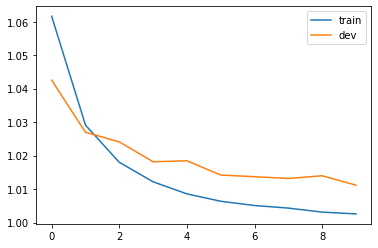

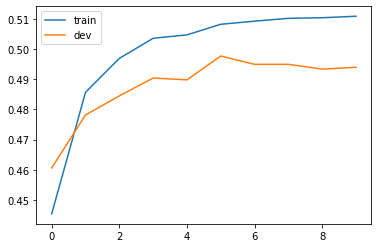

In [120]:
plt.plot(train_loss, label='train')
plt.plot(dev_loss, label='dev')
plt.legend()
plt.show()
plt.plot(train_acc, label='train')
plt.plot(dev_acc, label='dev')
plt.legend()
plt.show()

In [121]:
# evaluate on the test set
with torch.no_grad():
    running_loss = 0.0
    running_acc = 0.0
    for i, (tfidf, sentiment) in enumerate(test_loader):
        tfidf = tfidf.to(device)
        sentiment = sentiment.to(device)
        outputs = model(tfidf)
        loss = loss_fn(outputs, sentiment)
        running_loss += loss.item()
        running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
    test_loss = running_loss / len(test_loader)
    test_acc = running_acc / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 1.0187, Test Accuracy: 0.4963
